In [5]:
import numpy as np
import os 
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
import warnings
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import SplineTransformer, QuantileTransformer
from scipy import stats
import scipy.stats
import seaborn as sns
import tensorflow as tf
import scipy.io
from tqdm import tqdm
import pickle
import time

In [6]:
import encoding_GLM as glm

In [7]:
print(tf.config.experimental.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
from itertools import accumulate
from collections import Counter

def get_data_from_each_CV_fold(train_directory, test_directory, fold):
    directory_train = train_directory.format(fold)
    os.chdir(directory_train)

    behav = scipy.io.loadmat('behav_big_matrix.mat')
    behav_ids = scipy.io.loadmat('behav_big_matrix_ids.mat')

    behav_matrix = behav['behav_big_matrix']
    behav_ids_matrix = behav_ids['behav_big_matrix_ids'][0]

    response = scipy.io.loadmat('combined_response.mat')
    response_matrix = response['combined_response']
    response_matrix[response_matrix > 0.05] = 1

    X_train = behav_matrix
    Y_train = response_matrix
    
    behav_IDS = []
    for trial in list(range(behav_ids['behav_big_matrix_ids'][0].shape[0])):
        behav_IDS.append(behav_ids['behav_big_matrix_ids'][0][trial][0])

    # Count the occurrences of each element in the list
    counter = Counter(behav_IDS)

    # Get the unique values
    unique_values = list(counter.keys())

    # Get the count of each unique value
    count_of_values = list(counter.values())

    IDS_index = np.array(list(accumulate(count_of_values)))-1
    IDS_for_count_of_values = []
    for index in IDS_index[0:418]:
        IDS_for_count_of_values.append(behav_IDS[index])
        
    directory_test = test_directory.format(fold)
    os.chdir(directory_test)

    behav = scipy.io.loadmat('behav_big_matrix.mat')
    behav_ids = scipy.io.loadmat('behav_big_matrix_ids.mat')

    behav_matrix = behav['behav_big_matrix']
    behav_ids_matrix = behav_ids['behav_big_matrix_ids'][0]

    response = scipy.io.loadmat('combined_response.mat')
    response_matrix = response['combined_response']
    response_matrix[response_matrix > 0.05] = 1

    X_test = behav_matrix
    Y_test = response_matrix
    
    # Clean up design matrix and z-score along sample dimension
    X_train = X_train.T
    # Multiply deconvolved activity by 10 to mimic spike number
    Y_train = 10 * Y_train.T

    X_test = X_test.T
    # Multiply deconvolved activity by 10 to mimic spike number
    Y_test = 10 * Y_test.T
    
    return X_train, Y_train, X_test, Y_test, count_of_values, IDS_for_count_of_values

In [9]:
def train_model_on_cv_fold(X_train, Y_train, count_of_values):
    # Reset keras states
    tf.keras.backend.clear_session()

    model = glm.GLM(activation = 'exp', loss_type = 'poisson', 
                    regularization = 'elastic_net', lambda_series = 10.0 ** np.linspace(-1, -8, 10), 
                    l1_ratio = 0.98, smooth_strength = 0., 
                    optimizer = 'adam', learning_rate = 1e-3)
    
    model.fit(X_train, Y_train, feature_group_size = count_of_values, verbose = False) 
    
    return model

def train_model_on_cv_fold_GPU(X_train, Y_train, count_of_values):
    # Ensure the function runs on GPU
    with tf.device('/GPU:0'):
        # Reset keras states
        tf.keras.backend.clear_session()

        model = glm.GLM(activation = 'exp', loss_type = 'poisson', 
                        regularization = 'elastic_net', lambda_series = 10.0 ** np.linspace(-1, -8, 10), 
                        l1_ratio = 0.98, smooth_strength = 0., 
                        optimizer = 'adam', learning_rate = 1e-3)
        # Capture the start time
        start_time = time.time()
        
        # Fit the model
        model.fit(X_train, Y_train, feature_group_size=count_of_values, verbose=False) 
        
        # Capture the end time
        end_time = time.time()

    print(f"Time taken on GPU: {end_time - start_time:.4f} seconds")
    
    return model

In [10]:
for dataset in ['PPC B67 0629', 'PPC B67 0716', 'PPC B68 0628', 'PPC B68 0630', 'PPC B68 0703', 'PPC B77 0828', 
                'A1 B67 0703', 'A1 B68 0702', 'A1 B75 0908','A1 B77 0905']:
    directory = "/Volumes/Runyan2/Akhil/Runyan-Piasini-2017-master/Data/{}/state1_model".format(dataset) 
    frac_dev_expl_all = []
    for fold_number in list(range(0,10)):
        train_directory = directory + "/prepost trial cv 73 #{}".format(fold_number+1)
        test_directory = directory + "/prepost trial cv 73 #{}/test".format(fold_number+1)

        for i in tqdm(range(5)):
            [X_train, Y_train, X_test, Y_test, count_of_values, IDS_for_count_of_values] = get_data_from_each_CV_fold(train_directory,
                                                                                                                      test_directory,
                                                                                                                      fold_number+1)
        model_trained = train_model_on_cv_fold_GPU(X_train, Y_train, count_of_values)
        model_trained.select_model(X_test, Y_test, min_lambda = 0.0, make_fig = False)
        frac_dev_expl, dev_model, dev_null, dev_expl = model_trained.evaluate(X_test, Y_test, make_fig = False)
        B_weights = model_trained.selected_w
        intercept_weight = model_trained.selected_w0
        y_pred = model_trained.predict(X_test)
        selec_lambda = model_trained.selected_lambda
        
        model_data = {
            'frac_dev_expl': frac_dev_expl,
            'dev_model': dev_model,
            'dev_null': dev_null, 
            'dev_expl': dev_expl, 
            'B_weights': B_weights,
            'intercept_weight': intercept_weight,
            'y_pred': y_pred,
            'selec_lambda': selec_lambda
        }
        
        os.chdir(train_directory)

        with open('model_data_a95_GPU.pkl', 'wb') as file:
            pickle.dump(model_data, file)
            
        frac_dev_expl_all.append(model_data['frac_dev_expl'])
    
    frac_dev_expl_all_state1 = np.array(frac_dev_expl_all, dtype=object)
    save_directory = "/Volumes/Runyan2/Akhil/Runyan-Piasini-2017-master/Data/{}".format(dataset)
    os.chdir(save_directory)
    np.save('performance_state1_a98_GPU.npy', frac_dev_expl_all_state1)
    print(dataset + ' - DONE')

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  3.18it/s]
2023-10-23 10:53:20.432915: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Ultra
2023-10-23 10:53:20.432932: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2023-10-23 10:53:20.432946: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2023-10-23 10:53:20.432976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-23 10:53:20.432991: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Time taken on GPU: 281.7908 seconds
Fraction deviance explained: mean = 0.0675, median = 0.0861


100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


Time taken on GPU: 283.1074 seconds
Fraction deviance explained: mean = 0.1039, median = 0.1194


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Time taken on GPU: 285.4077 seconds
Fraction deviance explained: mean = -59055017008820147790510307017752576.0000, median = 0.0861


100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


Time taken on GPU: 294.3610 seconds
Fraction deviance explained: mean = 0.1415, median = 0.0751


100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Time taken on GPU: 288.7947 seconds
Fraction deviance explained: mean = 0.1091, median = 0.1348


100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


Time taken on GPU: 292.5612 seconds
Fraction deviance explained: mean = 0.1074, median = 0.0988


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


Time taken on GPU: 291.1003 seconds
Fraction deviance explained: mean = 0.0435, median = 0.0916


100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


Time taken on GPU: 290.2835 seconds
Fraction deviance explained: mean = 0.0882, median = 0.1414


100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


Time taken on GPU: 289.6059 seconds
Fraction deviance explained: mean = 0.1305, median = 0.1245


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Time taken on GPU: 289.1003 seconds
Fraction deviance explained: mean = 0.1217, median = 0.0929
PPC B67 0629 - DONE


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Time taken on GPU: 315.6099 seconds
Fraction deviance explained: mean = -30713239119730500064557780353155072.0000, median = 0.0321


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Time taken on GPU: 315.0552 seconds
Fraction deviance explained: mean = -30069877751244161888387090941476864.0000, median = 0.0150


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Time taken on GPU: 313.9506 seconds
Fraction deviance explained: mean = -33598101601361704058923423998410752.0000, median = 0.0239


100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


Time taken on GPU: 311.3851 seconds
Fraction deviance explained: mean = -31777575609416175509765869289865216.0000, median = 0.0318


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Time taken on GPU: 303.7417 seconds
Fraction deviance explained: mean = -30021179454733295129935914807066624.0000, median = 0.0148


100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Time taken on GPU: 316.8712 seconds
Fraction deviance explained: mean = -30809345307748702097436210133729280.0000, median = 0.0334


100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Time taken on GPU: 311.7917 seconds
Fraction deviance explained: mean = -29997395272239753073150454967304192.0000, median = 0.0335


100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Time taken on GPU: 313.9361 seconds
Fraction deviance explained: mean = -33014870616119291382208851454459904.0000, median = 0.0215


100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Time taken on GPU: 307.9622 seconds
Fraction deviance explained: mean = -32977188556939437430407646553309184.0000, median = 0.0247


100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Time taken on GPU: 306.7119 seconds
Fraction deviance explained: mean = -27745048141523904921249232034201600.0000, median = 0.0192
PPC B67 0716 - DONE


100%|██████████| 5/5 [00:00<00:00,  6.10it/s]


Time taken on GPU: 355.6873 seconds
Fraction deviance explained: mean = 0.0262, median = 0.0211


100%|██████████| 5/5 [00:00<00:00,  5.94it/s]


Time taken on GPU: 360.2618 seconds
Fraction deviance explained: mean = 0.0231, median = 0.0165


100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Time taken on GPU: 374.2982 seconds
Fraction deviance explained: mean = 0.0211, median = 0.0013


100%|██████████| 5/5 [00:00<00:00,  6.21it/s]


Time taken on GPU: 365.8320 seconds
Fraction deviance explained: mean = 0.0312, median = 0.0142


100%|██████████| 5/5 [00:00<00:00,  6.18it/s]


Time taken on GPU: 1637.1852 seconds
Fraction deviance explained: mean = 0.0374, median = 0.0161


100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Time taken on GPU: 2230.6728 seconds
Fraction deviance explained: mean = 0.0425, median = 0.0225


100%|██████████| 5/5 [00:00<00:00,  5.97it/s]


Time taken on GPU: 818.5439 seconds
Fraction deviance explained: mean = 0.0377, median = 0.0386


100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


Time taken on GPU: 359.7869 seconds
Fraction deviance explained: mean = -0.0028, median = 0.0069


100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


Time taken on GPU: 368.3489 seconds
Fraction deviance explained: mean = 0.0290, median = 0.0077


100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


Time taken on GPU: 368.5423 seconds
Fraction deviance explained: mean = 0.0342, median = 0.0205
PPC B68 0628 - DONE


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Time taken on GPU: 272.4225 seconds
Fraction deviance explained: mean = -40358722890487892405541174555705344.0000, median = 0.0267


100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Time taken on GPU: 272.8349 seconds
Fraction deviance explained: mean = -41761366953090803413426574270136320.0000, median = 0.0261


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Time taken on GPU: 275.1789 seconds
Fraction deviance explained: mean = -38858873470558154931928544300761088.0000, median = 0.0258


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Time taken on GPU: 269.6825 seconds
Fraction deviance explained: mean = -44859422872562019999675663815540736.0000, median = 0.0088


100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Time taken on GPU: 274.7473 seconds
Fraction deviance explained: mean = -40746085378678479423121241191481344.0000, median = 0.0229


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Time taken on GPU: 275.3776 seconds
Fraction deviance explained: mean = -40375795002755507761135757993967616.0000, median = 0.0319


100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Time taken on GPU: 276.5257 seconds
Fraction deviance explained: mean = -41106175026110554369685309892853760.0000, median = 0.0209


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Time taken on GPU: 270.6637 seconds
Fraction deviance explained: mean = -41454488797417039189755236605493248.0000, median = 0.0262


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Time taken on GPU: 276.7664 seconds
Fraction deviance explained: mean = -38588057821669971555677033281355776.0000, median = 0.0233


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Time taken on GPU: 281.1721 seconds
Fraction deviance explained: mean = -39356436035555023586511814068797440.0000, median = 0.0306
PPC B68 0630 - DONE


100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Time taken on GPU: 326.4293 seconds
Fraction deviance explained: mean = 0.0427, median = 0.0280


100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Time taken on GPU: 324.0931 seconds
Fraction deviance explained: mean = 0.0412, median = 0.0175


100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


Time taken on GPU: 325.0302 seconds
Fraction deviance explained: mean = 0.0389, median = 0.0218


100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


Time taken on GPU: 329.5431 seconds
Fraction deviance explained: mean = 0.0486, median = 0.0188


100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


Time taken on GPU: 328.9400 seconds
Fraction deviance explained: mean = 0.0334, median = 0.0124


100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


Time taken on GPU: 325.4263 seconds
Fraction deviance explained: mean = 0.0447, median = 0.0198


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Time taken on GPU: 326.4281 seconds
Fraction deviance explained: mean = 0.0450, median = 0.0210


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


Time taken on GPU: 329.7427 seconds
Fraction deviance explained: mean = 0.0407, median = 0.0222


100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Time taken on GPU: 323.7310 seconds
Fraction deviance explained: mean = 0.0149, median = 0.0061


100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


Time taken on GPU: 319.6669 seconds
Fraction deviance explained: mean = 0.0367, median = 0.0182
PPC B68 0703 - DONE


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Time taken on GPU: 310.8614 seconds
Fraction deviance explained: mean = 0.1163, median = 0.0923


100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Time taken on GPU: 303.4013 seconds
Fraction deviance explained: mean = 0.1109, median = 0.0962


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Time taken on GPU: 305.2474 seconds
Fraction deviance explained: mean = 0.1173, median = 0.0916


100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


Time taken on GPU: 1282.8494 seconds
Fraction deviance explained: mean = 0.1264, median = 0.1071


100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Time taken on GPU: 1217.4677 seconds
Fraction deviance explained: mean = 0.1218, median = 0.0915


100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Time taken on GPU: 1233.2268 seconds
Fraction deviance explained: mean = 0.1232, median = 0.0994


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Time taken on GPU: 2168.7326 seconds
Fraction deviance explained: mean = 0.1343, median = 0.1105


100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Time taken on GPU: 1228.8396 seconds
Fraction deviance explained: mean = 0.1218, median = 0.0869


100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Time taken on GPU: 2159.2442 seconds
Fraction deviance explained: mean = 0.1318, median = 0.1099


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Time taken on GPU: 1199.3814 seconds
Fraction deviance explained: mean = 0.1206, median = 0.1096
PPC B77 0828 - DONE


100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


Time taken on GPU: 2240.2205 seconds
Fraction deviance explained: mean = 0.0988, median = 0.0459


100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


Time taken on GPU: 2242.3303 seconds
Fraction deviance explained: mean = 0.0904, median = 0.0465


100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Time taken on GPU: 2504.6804 seconds
Fraction deviance explained: mean = 0.0759, median = 0.0608


100%|██████████| 5/5 [00:01<00:00,  3.81it/s]


Time taken on GPU: 1283.5322 seconds
Fraction deviance explained: mean = 0.0829, median = 0.0598


100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


Time taken on GPU: 3375.7521 seconds
Fraction deviance explained: mean = 0.0836, median = 0.0412


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


Time taken on GPU: 721.7948 seconds
Fraction deviance explained: mean = 0.0835, median = 0.0741


100%|██████████| 5/5 [00:01<00:00,  3.97it/s]


Time taken on GPU: 3140.7286 seconds
Fraction deviance explained: mean = 0.0726, median = 0.0370


100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


Time taken on GPU: 554.7788 seconds
Fraction deviance explained: mean = 0.0820, median = 0.0502


100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Time taken on GPU: 798.2334 seconds
Fraction deviance explained: mean = 0.0791, median = 0.0435


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Time taken on GPU: 2075.7886 seconds
Fraction deviance explained: mean = 0.0956, median = 0.0486
A1 B67 0703 - DONE


100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Time taken on GPU: 2561.3563 seconds
Fraction deviance explained: mean = 0.0785, median = 0.0490


100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


Time taken on GPU: 1247.2268 seconds
Fraction deviance explained: mean = 0.0933, median = 0.0845


100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


Time taken on GPU: 3152.1060 seconds
Fraction deviance explained: mean = 0.0902, median = 0.0594


100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


Time taken on GPU: 1285.5527 seconds
Fraction deviance explained: mean = 0.1038, median = 0.0804


100%|██████████| 5/5 [00:01<00:00,  4.01it/s]


Time taken on GPU: 3089.6472 seconds
Fraction deviance explained: mean = 0.0981, median = 0.0711


100%|██████████| 5/5 [00:01<00:00,  4.07it/s]


Time taken on GPU: 1235.7738 seconds
Fraction deviance explained: mean = 0.0953, median = 0.0699


100%|██████████| 5/5 [00:01<00:00,  4.10it/s]


Time taken on GPU: 2028.0441 seconds
Fraction deviance explained: mean = 0.0862, median = 0.0775


100%|██████████| 5/5 [00:01<00:00,  3.93it/s]


Time taken on GPU: 2171.8008 seconds
Fraction deviance explained: mean = 0.1087, median = 0.0762


100%|██████████| 5/5 [00:01<00:00,  4.10it/s]


Time taken on GPU: 2148.3505 seconds
Fraction deviance explained: mean = 0.1052, median = 0.0735


100%|██████████| 5/5 [00:01<00:00,  3.78it/s]


Time taken on GPU: 1267.7078 seconds
Fraction deviance explained: mean = 0.0846, median = 0.0544
A1 B68 0702 - DONE


100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Time taken on GPU: 2716.8435 seconds
Fraction deviance explained: mean = 0.0736, median = 0.0454


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Time taken on GPU: 2210.4383 seconds
Fraction deviance explained: mean = 0.0832, median = 0.0558


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Time taken on GPU: 526.4644 seconds
Fraction deviance explained: mean = 0.0809, median = 0.0569


100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Time taken on GPU: 2277.0243 seconds
Fraction deviance explained: mean = 0.0821, median = 0.0348


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Time taken on GPU: 2204.4496 seconds
Fraction deviance explained: mean = 0.0871, median = 0.0446


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Time taken on GPU: 2184.7166 seconds
Fraction deviance explained: mean = 0.0914, median = 0.0391


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


KeyboardInterrupt: 

# Compare size of training and test datasets between models

In [16]:
def get_data_size(model):
    X_train_size = []
    X_test_size = []
    for dataset in A1_datasets:
        directory = train_directory = "C:\Code\Runyan-Piasini-2017-master\Data\{}\\{}".format(dataset, model)

        models_for_each_fold = []
        for fold_number in list(range(0,10)):
            train_directory = directory + "\prepost trial cv 73 #{}".format(fold_number+1)
            test_directory = directory + "\prepost trial cv 73 #{}\\test".format(fold_number+1)

            for i in tqdm(range(5)):
                [X_train, Y_train, X_test, Y_test, count_of_values, IDS_for_count_of_values] = get_data_from_each_CV_fold(train_directory,
                                                                                                                          test_directory,
                                                                                                                         fold_number+1)

            X_train_size.append(X_train.shape[0])    
            X_test_size.append(X_test.shape[0])    
    return X_train_size, X_test_size

In [17]:
model = 'state1_model'
X_train_size, X_test_size = get_data_size(model)

model = 'all_state_model'
X_train_size_stall, X_test_size_stall = get_data_size(model)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.77it/s]


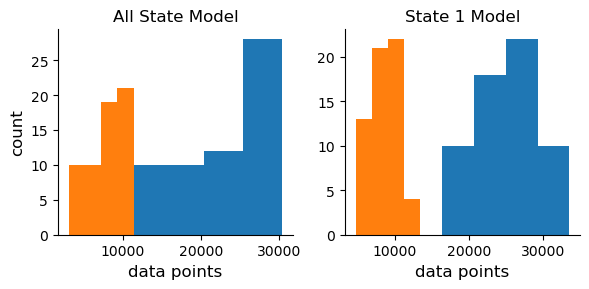

In [125]:
fig,axs = plt.subplots(1, 2, figsize = (6,3))

axs[0].hist(X_train_size, bins=4)
axs[0].hist(X_test_size, bins=4)
axs[0].spines['top'].set_visible(False) 
axs[0].spines['right'].set_visible(False)
axs[0].set_ylabel('count', fontsize=12)
axs[0].set_xlabel('data points', fontsize=12)
axs[0].set_title('All State Model', fontsize=12)


axs[1].hist(X_train_size_stall, bins=4)
axs[1].hist(X_test_size_stall, bins=4)
axs[1].spines['top'].set_visible(False) 
axs[1].spines['right'].set_visible(False)
axs[1].set_xlabel('data points', fontsize=12)
axs[1].set_title('State 1 Model', fontsize=12)


plt.tight_layout()